In [23]:
import numpy as np
import matplotlib.pyplot as plt

depth_buffer = np.load('test_depth.npy')
depth = depth_buffer[:, :, 0]

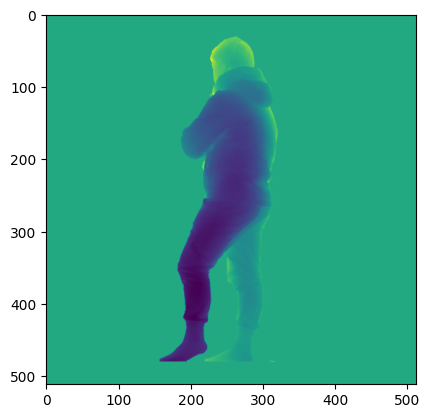

In [24]:
plt.imshow(depth)

In [33]:
depth_new = (depth + 1) / 2

near_plane = 1  # Near plane distance in your scene
far_plane = 10.0  # Far plane distance in your scene

normalized_depth = depth_new
actual_depth = normalized_depth * (far_plane - near_plane) + near_plane
actual_depth_2 = actual_depth * 1000

In [41]:
depth_image = Image.fromarray(actual_depth_2.astype('uint32'), 'I')
depth_image.save('depth_map_uint32.png')

In [42]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

depth2 = np.array(Image.open("depth_map_uint32.png"))

In [47]:
depth2.shape

(512, 512)

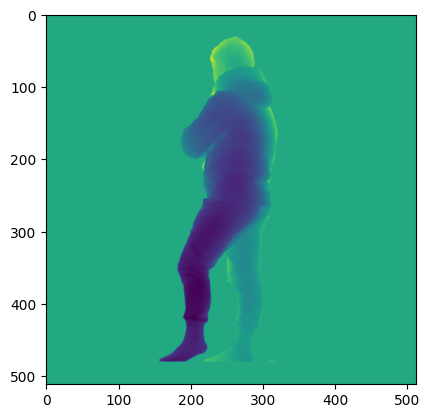

In [45]:
plt.imshow(depth2)

In [31]:
def get_intrinsics(H,W):
    """
    Intrinsics for a pinhole camera model.
    Assume fov of 55 degrees and central principal point.
    """
    f = 0.5 * W / np.tan(0.5 * 600 * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])

def depth_to_points(depth, R=None, t=None):
    
    # Generate sample coordinates
    x = np.linspace(-5/ 2, 5 / 2, depth.shape[2])
    y = np.linspace(5 / 2, -5/ 2, depth.shape[1])
    xx, yy = np.meshgrid(x, y)

    # Reshape the depth map and stack to get 3D points
    zz = depth.reshape(-1)
    points = np.stack((xx.reshape(-1), yy.reshape(-1), zz), axis=-1)

    return points


pts3d = depth_to_points(actual_depth[np.newaxis, ...])
pts3d = pts3d.reshape(-1, 3)


import open3d as o3d

# create o3d point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d)

# write o3d point cloud
o3d.io.write_point_cloud("10.ply", pcd)
# o3d.visualization.draw_geometries([pcd])

True

In [48]:
def get_intrinsics(H,W):
    """
    Intrinsics for a pinhole camera model.
    Assume fov of 55 degrees and central principal point.
    """
    f = 0.5 * W / np.tan(0.5 * 75 * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])

def depth_to_points(depth, R=None, t=None):

    K = get_intrinsics(depth.shape[1], depth.shape[2])
    print(K)
    Kinv = np.linalg.inv(K)
    if R is None:
        R = np.eye(3)
    if t is None:
        t = np.zeros(3)

    # M converts from your coordinate to PyTorch3D's coordinate system
    M = np.eye(3)
    M[0, 0] = -1.0
    M[1, 1] = -1.0

    height, width = depth.shape[1:3]

    x = np.arange(width)
    y = np.arange(height)
    coord = np.stack(np.meshgrid(x, y), -1)
    coord = np.concatenate((coord, np.ones_like(coord)[:, :, [0]]), -1)  # z=1
    coord = coord.astype(np.float32)
    # coord = torch.as_tensor(coord, dtype=torch.float32, device=device)
    coord = coord[None]  # bs, h, w, 3

    D = depth[:, :, :, None, None]
    # print(D.shape, Kinv[None, None, None, ...].shape, coord[:, :, :, :, None].shape )
    pts3D_1 = D * Kinv[None, None, None, ...] @ coord[:, :, :, :, None]
    # pts3D_1 live in your coordinate system. Convert them to Py3D's
    pts3D_1 = M[None, None, None, ...] @ pts3D_1
    # from reference to targe tviewpoint
    pts3D_2 = R[None, None, None, ...] @ pts3D_1 + t[None, None, None, :, None]
    # pts3D_2 = pts3D_1
    # depth_2 = pts3D_2[:, :, :, 2, :]  # b,1,h,w
    return pts3D_2[:, :, :, :3, 0][0]


pts3d = depth_to_points(depth2[np.newaxis, ...])
pts3d = pts3d.reshape(-1, 3)

import open3d as o3d

# create o3d point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d)

# write o3d point cloud
o3d.io.write_point_cloud("10.ply", pcd)
# o3d.visualization.draw_geometries([pcd])

[[333.62569545   0.         256.        ]
 [  0.         333.62569545 256.        ]
 [  0.           0.           1.        ]]


True

In [18]:
depth_buffer[:,:,2].mean()

-0.020011427

In [174]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

path = '/home/yuxuan/project/ICON/debug/home/yuxuan/project/THuman2.0_Release_30views/0351'
img_name = '000.png'
color_path = os.path.join(path, 'render', img_name)
depth_path = os.path.join(path, 'depth_F', img_name)

color = np.array(Image.open(color_path))
depth = np.array(Image.open(depth_path))
mask = np.array(Image.open(depth_path.replace("png", "jpg")))
mask2 = np.array(Image.open(depth_path.replace("png", "jpg")))

In [180]:
mask[mask<=127] = 0

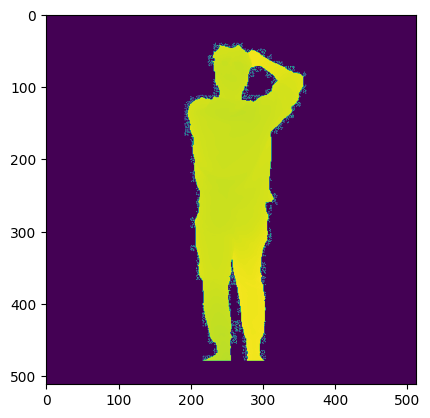

In [181]:
plt.imshow(depth)

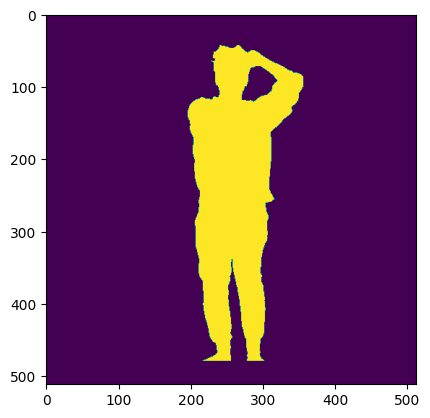

In [182]:
plt.imshow(mask)

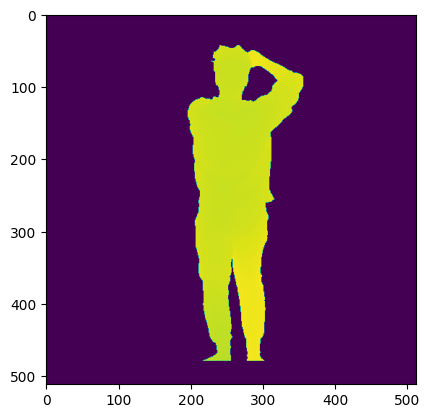

In [183]:
depth[mask==0] = 0
plt.imshow(depth)

In [184]:
def get_intrinsics(H,W):
    """
    Intrinsics for a pinhole camera model.
    Assume fov of 55 degrees and central principal point.
    """
    f = 0.5 * W / np.tan(0.5 * 600 * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])

def depth_to_points(depth, R=None, t=None):
    frustrum = 2
    # Generate sample coordinates
    x = np.linspace(-frustrum/ 2, frustrum/ 2, depth.shape[2])
    y = np.linspace(frustrum /2, -frustrum / 2, depth.shape[1])
    xx, yy = np.meshgrid(x, y)

    # Reshape the depth map and stack to get 3D points
    zz = depth.reshape(-1)
    points = np.stack((xx.reshape(-1), yy.reshape(-1), zz), axis=-1)

    return points

pts3d = depth_to_points((depth/1000)[np.newaxis, ...])
pts3d = pts3d.reshape(-1, 3)
image = np.array(color)[:,:,:3]
colors = image.reshape(-1, 3) / 255

pts3d = pts3d[mask.reshape(-1)!=0]
colors = colors[mask.reshape(-1)!=0]

import open3d as o3d

# create o3d point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d)
pcd.colors = o3d.utility.Vector3dVector(colors)

# write o3d point cloud
o3d.io.write_point_cloud("10.ply", pcd)
# o3d.visualization.draw_geometries([pcd])

True